In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import tree, metrics

In [4]:
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

In [5]:
import scipy.stats as ss

In [6]:
mush = pd.read_csv('mushrooms.csv')

In [7]:
mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

<AxesSubplot:xlabel='class', ylabel='Count'>

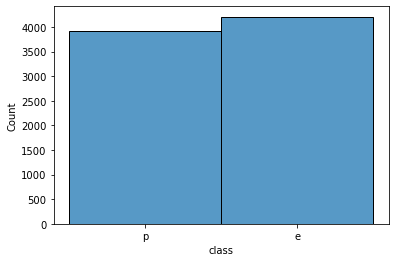

In [8]:
sns.histplot(data=mush,x='class')

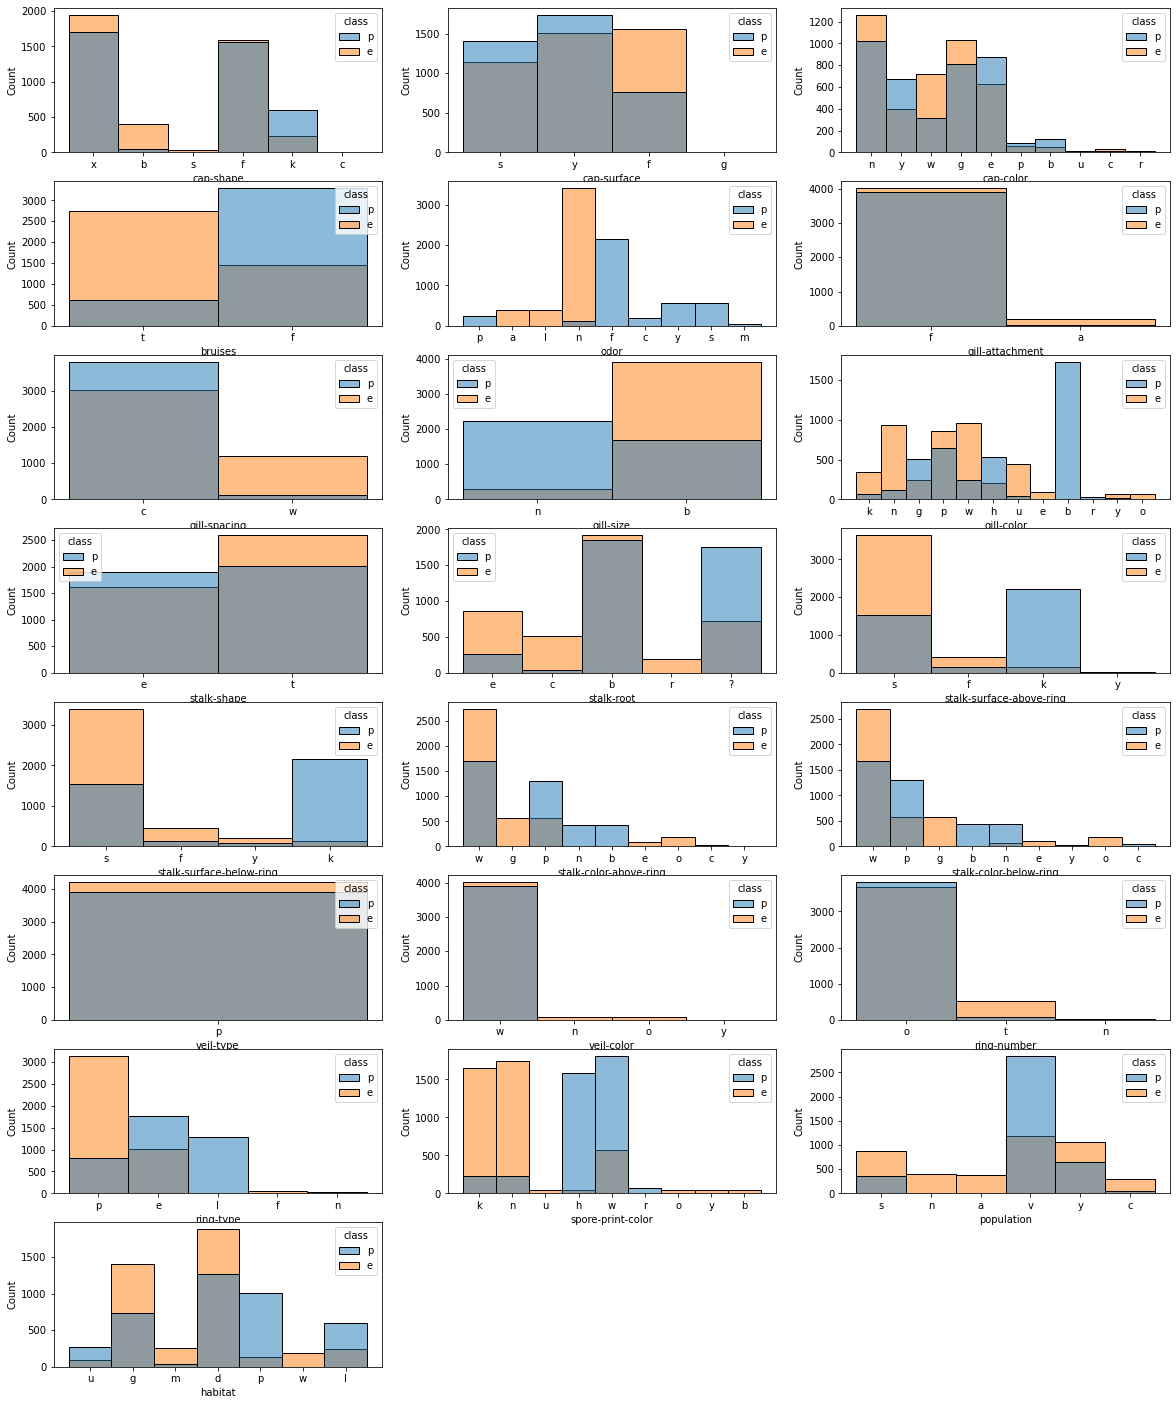

In [9]:
plt.figure(figsize=(20,25))
for i,x in enumerate(mush.columns[1:]):
    plt.subplot(8,3,i+1)
    sns.histplot(data=mush,x=x,hue='class')

In [10]:
## usuwamy veil-type - tylko jedna wartość zmiennej
mush.drop(labels='veil-type',axis=1,inplace=True)

In [11]:
## asocjacja zmiennych kategorycznych - miara V Cramera
def Cramer_V(x,y):
    conf_mat = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(conf_mat)[0]
    n = conf_mat.sum().sum()
    phi2 = chi2/n
    r,k = conf_mat.shape
    phi2corr = max(0, phi2 - ((r-1)*(k-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min(rcorr-1,kcorr-1))

In [12]:
Cramer_V(mush['habitat'],mush['population'])

0.5061756481988668

In [13]:
v_class=[]
for y in mush.columns:
    v_class.append(Cramer_V(mush['class'],mush[y]))

In [14]:
Cramer_V(mush['class'],mush['class'])

0.999753467046038

In [15]:
len(v_class)

22

In [16]:
v=[]
for y in mush.columns:
    for x in mush.columns:
        v.append(Cramer_V(mush[x],mush[y]))

In [17]:
len(v)

484

In [18]:
v_mat = round(pd.DataFrame(np.array(v).reshape(22,22),columns=mush.columns,index=mush.columns),2)

<AxesSubplot:>

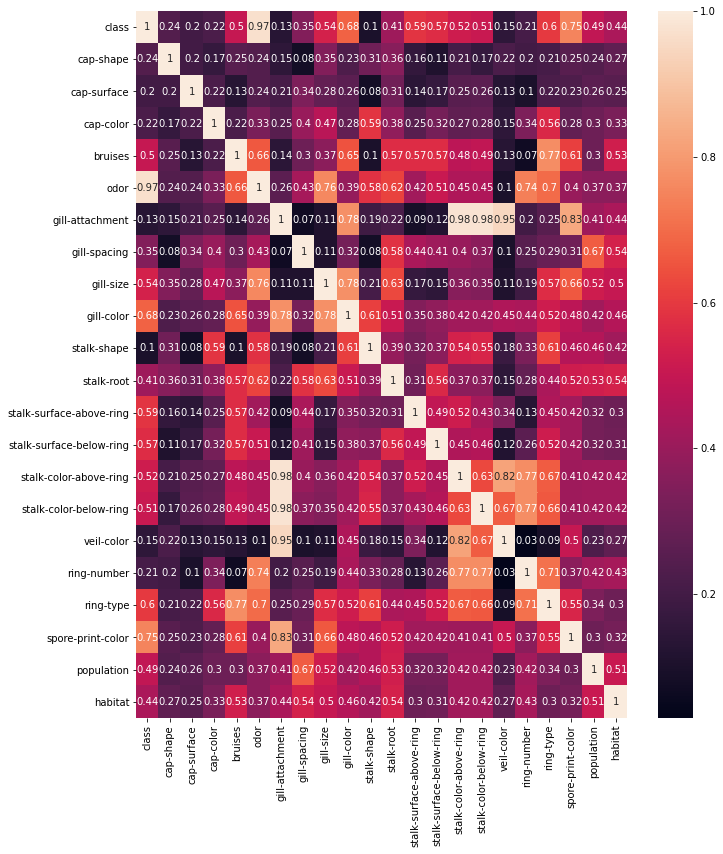

In [19]:
plt.figure(figsize=(11,13))
sns.heatmap(v_mat,annot=True)

In [20]:
v_mat[v_mat['class']>0.45]['class'].sort_values(ascending=False)

class                       1.00
odor                        0.97
spore-print-color           0.75
gill-color                  0.68
ring-type                   0.60
stalk-surface-above-ring    0.59
stalk-surface-below-ring    0.57
gill-size                   0.54
stalk-color-above-ring      0.52
stalk-color-below-ring      0.51
bruises                     0.50
population                  0.49
Name: class, dtype: float64

In [21]:
mush_dumm= pd.get_dummies(mush,drop_first=True)
mush_dumm.head()

class_p  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  cap-shape_x  \
0        1            0            0            0            0            1   
1        0            0            0            0            0            1   
2        0            0            0            0            0            0   
3        1            0            0            0            0            1   
4        0            0            0            0            0            1   

   cap-surface_g  cap-surface_s  cap-surface_y  cap-color_c  ...  \
0              0              1              0            0  ...   
1              0              1              0            0  ...   
2              0              1              0            0  ...   
3              0              0              1            0  ...   
4              0              1              0            0  ...   

   population_n  population_s  population_v  population_y  habitat_g  \
0             0             1             0             0          0   
1             1             0             0             0          1   
2             1             0             0             0          0   
3             0             1             0             0          0   
4             0             0             0             0          1   

   habitat_l  habitat_m  habitat_p  habitat_u  habitat_w  
0          0          0          0          1          0  
1          0          0          0          0          0  
2          0          1          0          0          0  
3          0          0          0          1          0  
4          0          0          0          0          0  

[5 rows x 96 columns]

In [72]:
x = mush_dumm.iloc[:,1:]
y = mush_dumm.class_p

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6499, 95)
(1625, 95)
(6499,)
(1625,)


In [74]:
y_test.value_counts()

0    852
1    773
Name: class_p, dtype: int64

In [26]:
models= pd.DataFrame(index=range(6),columns=['nazwa_modelu','accuracy','f1','auroc'])

### Single decision tree

In [27]:
dtree = tree.DecisionTreeClassifier()

In [28]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier()

In [29]:
dtree.score(x_test,y_test)

1.0

In [30]:
metrics.confusion_matrix(y_test,dtree.predict(x_test))

array([[852,   0],
       [  0, 773]], dtype=int64)

Text(992.0, 373.725, 'samples = 59\nvalue = [0, 59]\nclass = y[1]')

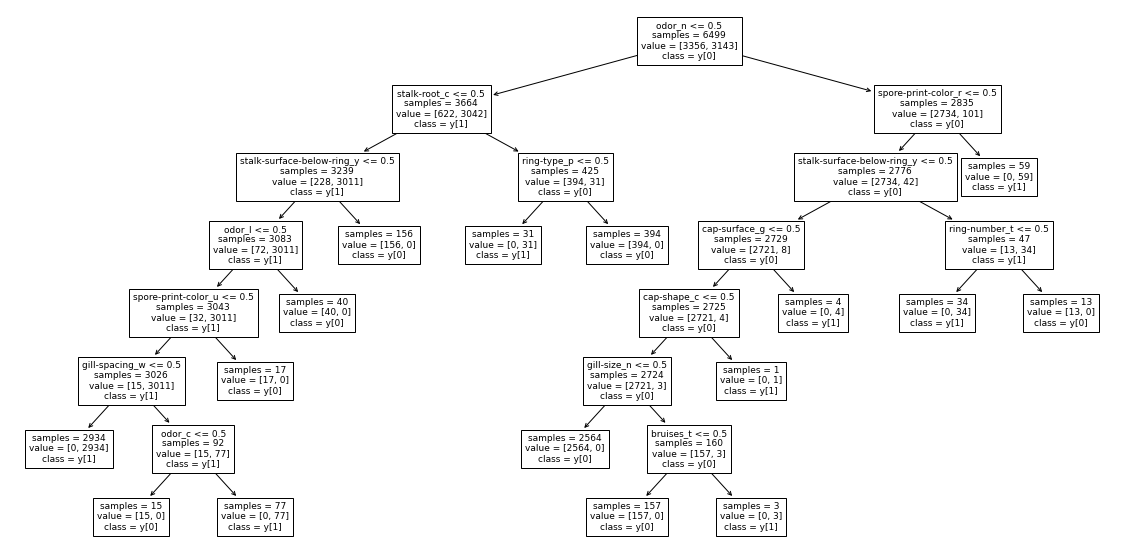

In [31]:
plt.figure(figsize=(20,10))
tree.plot_tree(dtree,feature_names=x.columns,class_names=True,impurity=False,fontsize=9)[-1]

In [32]:
tree_feat = pd.DataFrame(dtree.feature_importances_,index=x.columns,columns=['feature_importance'])

<AxesSubplot:>

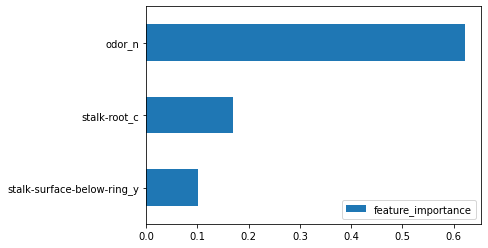

In [33]:
tree_feat[tree_feat['feature_importance']>0.1].sort_values('feature_importance').plot.barh()

In [75]:
models.loc[models.index==3,'nazwa_modelu'] = 'dtree'
models.loc[models.index==3,'accuracy'] = metrics.accuracy_score(y_test,dtree.predict(x_test))
models.loc[models.index==3,'f1'] = metrics.f1_score(y_test,dtree.predict(x_test))
models.loc[models.index==3,'auroc'] = metrics.roc_auc_score(y_test,dtree.predict(x_test))

### Adaptive boosting

In [34]:
ada_boost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)

In [35]:
ada_boost.fit(x_train,y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=100)

In [36]:
ada_boost.score(x_test,y_test)

0.9993846153846154

In [37]:
cm = metrics.confusion_matrix(y_test,ada_boost.predict(x_test),labels=(1,0))
cm

array([[772,   1],
       [  0, 852]], dtype=int64)

In [38]:
cm_df = pd.DataFrame(cm,index=['Real: Poison.', 'Real: Not poison.'], columns = ['Predicted: Poisonous', 'Predicted: Not poisonous'])

<AxesSubplot:>

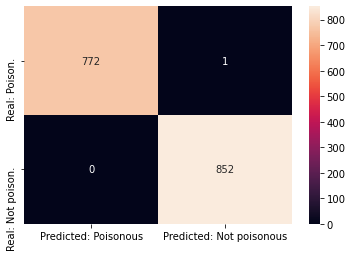

In [39]:
sns.heatmap(cm_df,annot=True,fmt='d')

In [40]:
print(metrics.classification_report(y_test,ada_boost.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       852
           1       1.00      1.00      1.00       773

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [41]:
metrics.accuracy_score(y_test,ada_boost.predict(x_test))

0.9993846153846154

In [42]:
metrics.f1_score(y_test,ada_boost.predict(x_test))

0.9993527508090615

In [43]:
fpr,tpr, threshold = metrics.roc_curve(y_test,ada_boost.predict(x_test))

Text(0, 0.5, 'True positive rate')

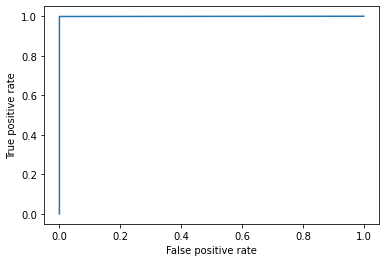

In [44]:
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [45]:
metrics.roc_auc_score(y_test,ada_boost.predict(x_test))

0.999353169469599

In [46]:
ada_boost.feature_importances_

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.02, 0.03, 0.01, 0.  ,
       0.2 , 0.02, 0.01, 0.01, 0.  , 0.05, 0.22, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.07, 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  ,
       0.  , 0.01, 0.  , 0.03, 0.  , 0.18, 0.  , 0.05, 0.  , 0.  , 0.03,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [47]:
feat_impo = pd.DataFrame(ada_boost.feature_importances_,index=x.columns,columns=['Feature_importance']).sort_values('Feature_importance',ascending=False)

<AxesSubplot:>

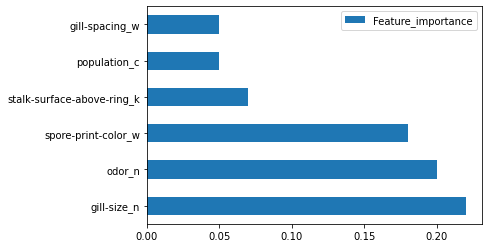

In [48]:
feat_impo[feat_impo['Feature_importance']>0.03].plot.barh()

In [49]:
models.loc[models.index==0,'nazwa_modelu'] = 'ada_boost'
models.loc[models.index==0,'accuracy'] = metrics.accuracy_score(y_test,ada_boost.predict(x_test))
models.loc[models.index==0,'f1'] = metrics.f1_score(y_test,ada_boost.predict(x_test))
models.loc[models.index==0,'auroc'] = metrics.roc_auc_score(y_test,ada_boost.predict(x_test))

### XGBoost

In [50]:
xgb_class = xgb.XGBClassifier(n_estimators=100,use_label_encoder=False)

In [51]:
xgb_class.fit(x_train,y_train)

[10:25:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [52]:
xgb_class.score(x_test,y_test)

1.0

In [53]:
cm = metrics.confusion_matrix(y_test,xgb_class.predict(x_test),labels=(1,0))

In [54]:
cm_df = pd.DataFrame(cm,index=['Real: Poison.', 'Real: Not poison.'], columns = ['Predicted: Poisonous', 'Predicted: Not poisonous'])

<AxesSubplot:>

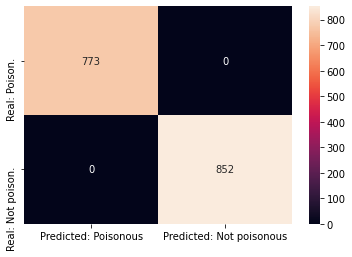

In [55]:
sns.heatmap(cm_df,annot=True,fmt='d')

In [56]:
feat_xgb = pd.DataFrame(xgb_class.feature_importances_,index=x.columns,columns=['Feature_importance']).sort_values('Feature_importance')

<AxesSubplot:>

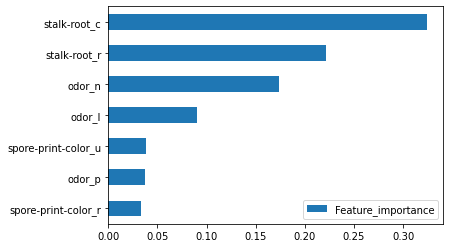

In [57]:
feat_xgb[feat_xgb['Feature_importance']>0.03].plot.barh()

In [58]:
models.loc[models.index==1,'nazwa_modelu'] = 'xgb_class'
models.loc[models.index==1,'accuracy'] = metrics.accuracy_score(y_test,xgb_class.predict(x_test))
models.loc[models.index==1,'f1'] = metrics.f1_score(y_test,xgb_class.predict(x_test))
models.loc[models.index==1,'auroc'] = metrics.roc_auc_score(y_test,xgb_class.predict(x_test))

### Catboost

In [59]:
x_cat = mush.iloc[:,1:]
y_cat = mush['class']

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x_cat,y_cat,test_size=0.2, random_state=0)

In [61]:
cat_boost = CatBoostClassifier(iterations=100)

In [62]:
cat_boost.fit(x_train,y_train, cat_features=x_cat.columns)

Learning rate set to 0.189243
0:	learn: 0.3469504	total: 192ms	remaining: 19s
1:	learn: 0.1926136	total: 234ms	remaining: 11.5s
2:	learn: 0.1284955	total: 277ms	remaining: 8.96s
3:	learn: 0.0660298	total: 322ms	remaining: 7.73s
4:	learn: 0.0320764	total: 372ms	remaining: 7.07s
5:	learn: 0.0182748	total: 435ms	remaining: 6.82s
6:	learn: 0.0128231	total: 501ms	remaining: 6.65s
7:	learn: 0.0083490	total: 546ms	remaining: 6.28s
8:	learn: 0.0066855	total: 600ms	remaining: 6.07s
9:	learn: 0.0054590	total: 652ms	remaining: 5.86s
10:	learn: 0.0041923	total: 711ms	remaining: 5.75s
11:	learn: 0.0040108	total: 767ms	remaining: 5.63s
12:	learn: 0.0033994	total: 819ms	remaining: 5.48s
13:	learn: 0.0031483	total: 867ms	remaining: 5.33s
14:	learn: 0.0030887	total: 914ms	remaining: 5.18s
15:	learn: 0.0030647	total: 958ms	remaining: 5.03s
16:	learn: 0.0027181	total: 998ms	remaining: 4.87s
17:	learn: 0.0024214	total: 1.04s	remaining: 4.73s
18:	learn: 0.0022296	total: 1.08s	remaining: 4.62s
19:	learn: 0.

In [63]:
cat_boost.score(x_test,y_test)

1.0

In [64]:
cm = metrics.confusion_matrix(y_test,cat_boost.predict(x_test),labels=['p','e'])

In [65]:
cm_df =  pd.DataFrame(cm,index=['Real: Poison.', 'Real: Not poison.'], columns = ['Predicted: Poisonous', 'Predicted: Not poisonous'])

<AxesSubplot:>

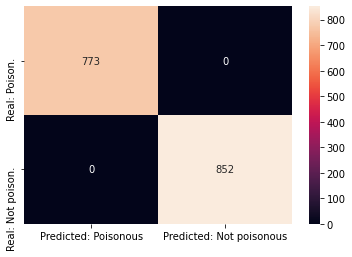

In [66]:
sns.heatmap(cm_df,annot=True,fmt='d')

In [67]:
feat_cat = round(pd.DataFrame(cat_boost.feature_importances_,index=x_cat.columns,columns=['Feature_importance']).sort_values('Feature_importance'),4)

<AxesSubplot:>

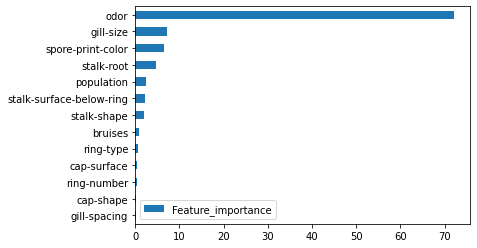

In [68]:
feat_cat[feat_cat['Feature_importance']>0.03].plot.barh()

In [69]:
models.loc[models.index==2,'nazwa_modelu'] = 'cat_boost'
models.loc[models.index==2,'accuracy'] = metrics.accuracy_score(y_test,cat_boost.predict(x_test))
models.loc[models.index==2,'f1'] = metrics.f1_score(y_test,cat_boost.predict(x_test),labels=['p','e'],pos_label='p')

In [76]:
models

nazwa_modelu  accuracy        f1     auroc
0    ada_boost  0.999385  0.999353  0.999353
1    xgb_class         1         1         1
2    cat_boost         1         1       NaN
3        dtree         1         1         1
4          NaN       NaN       NaN       NaN
5          NaN       NaN       NaN       NaN